Summary-Table erstellt


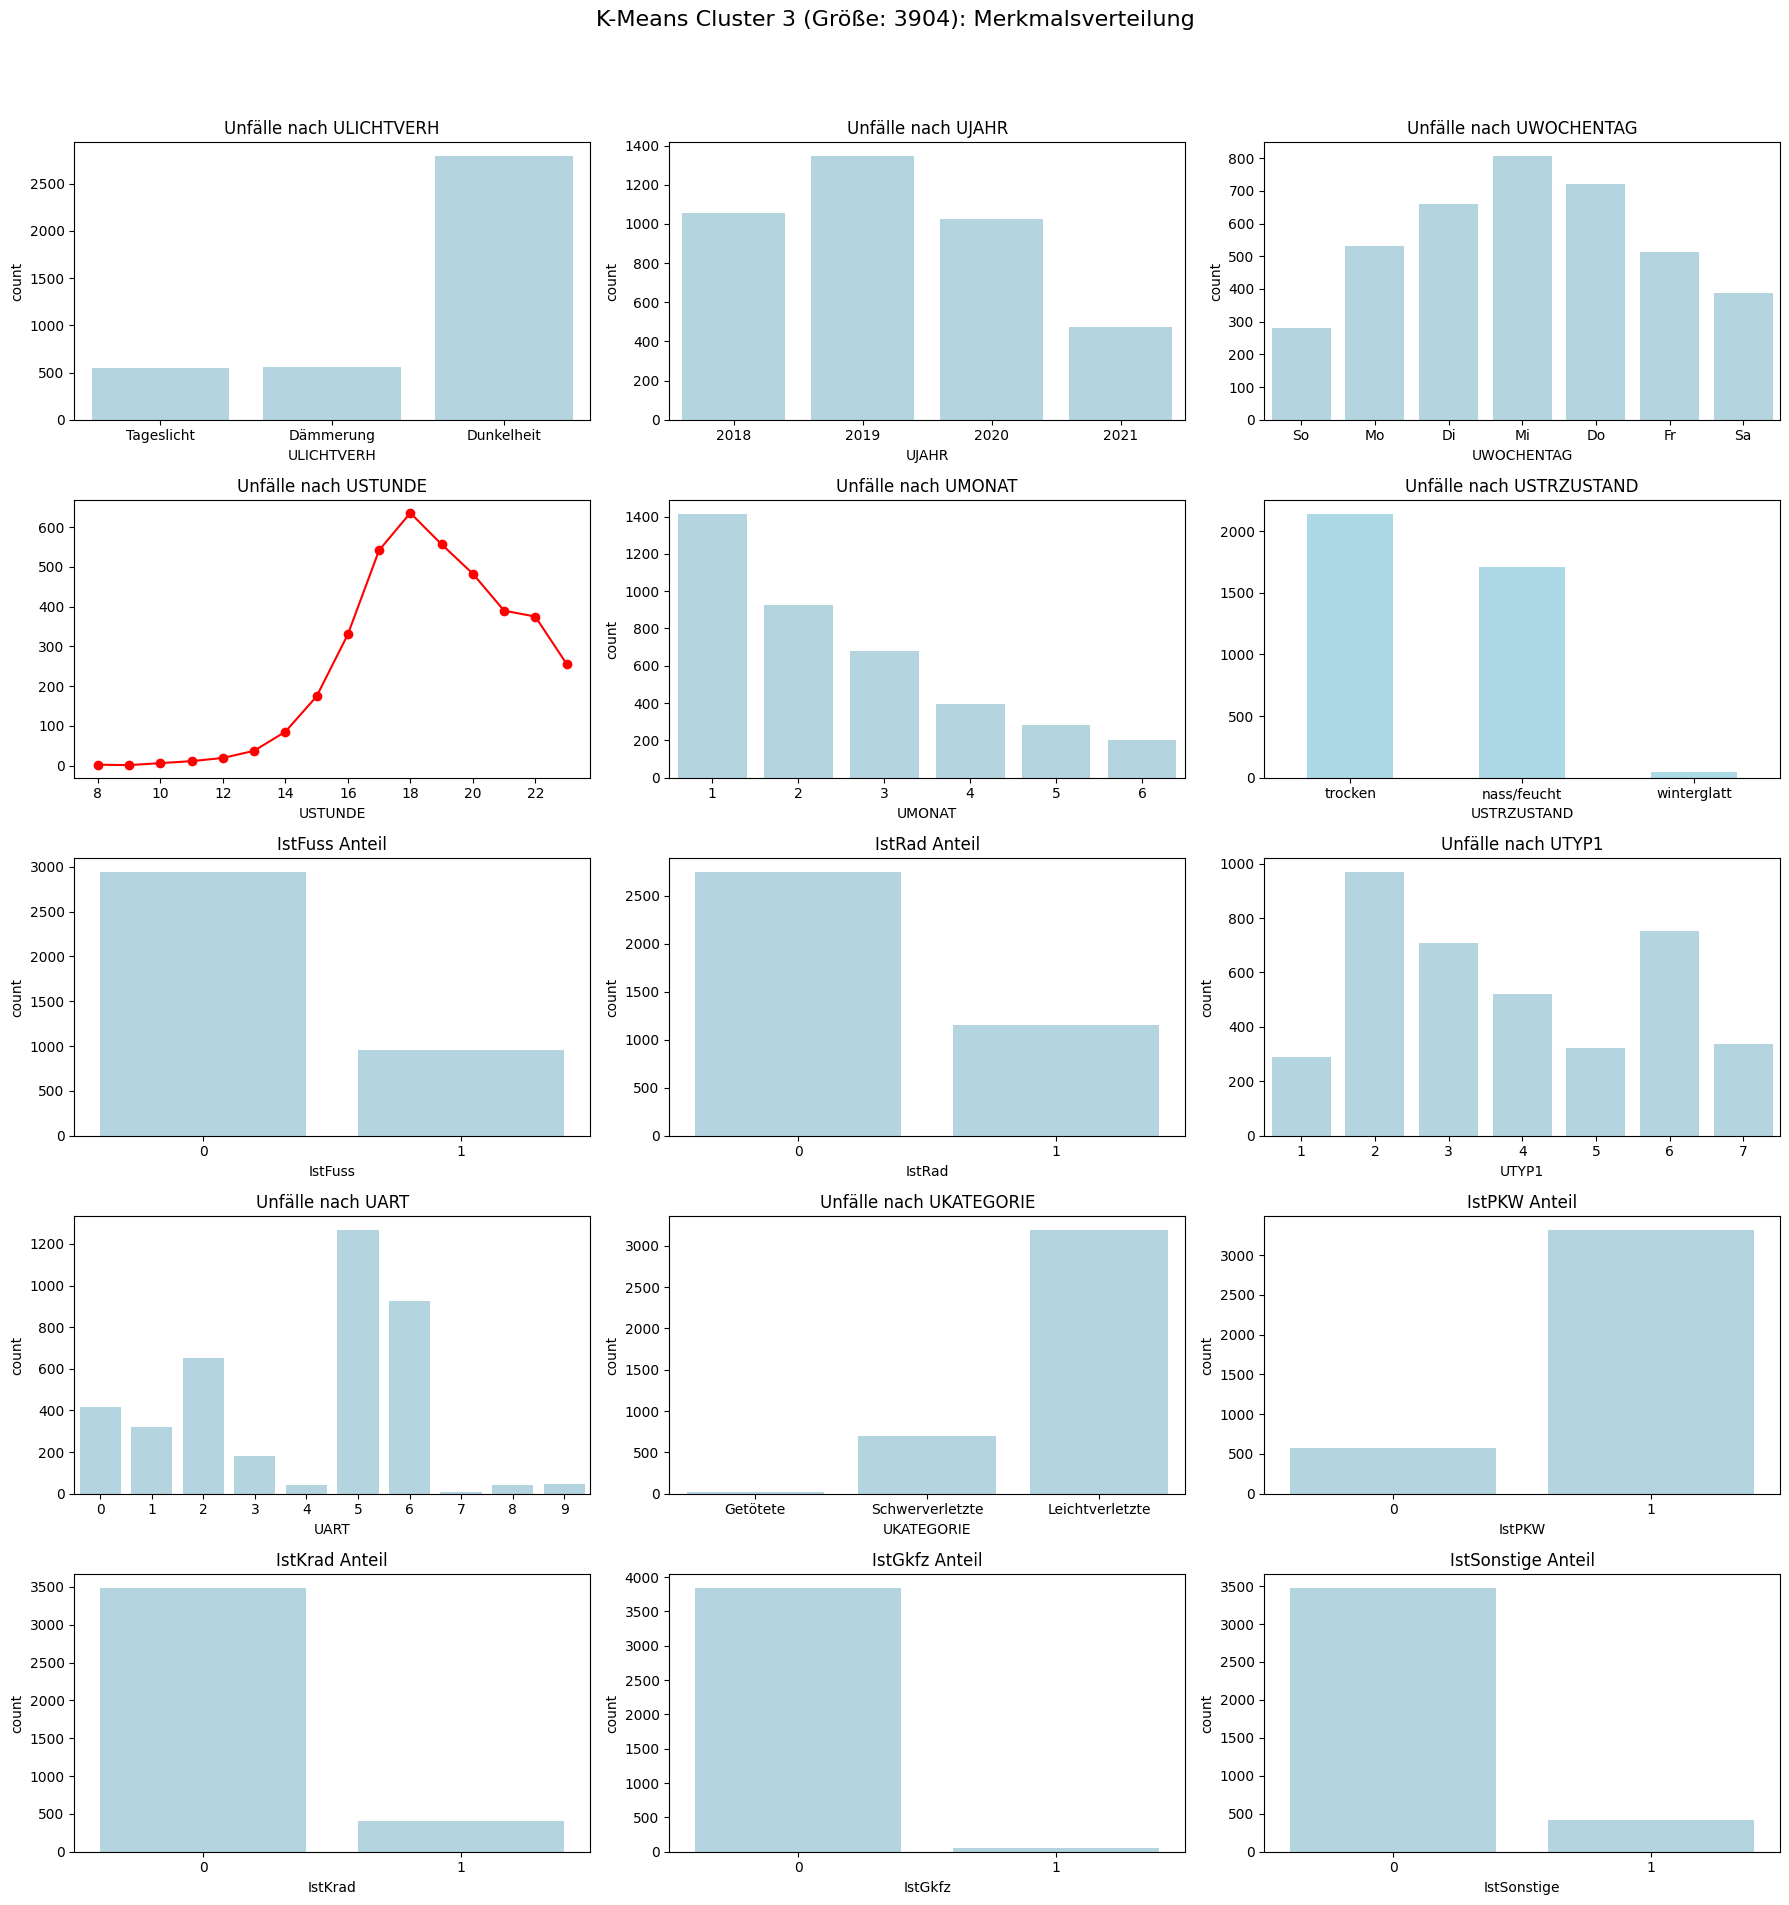

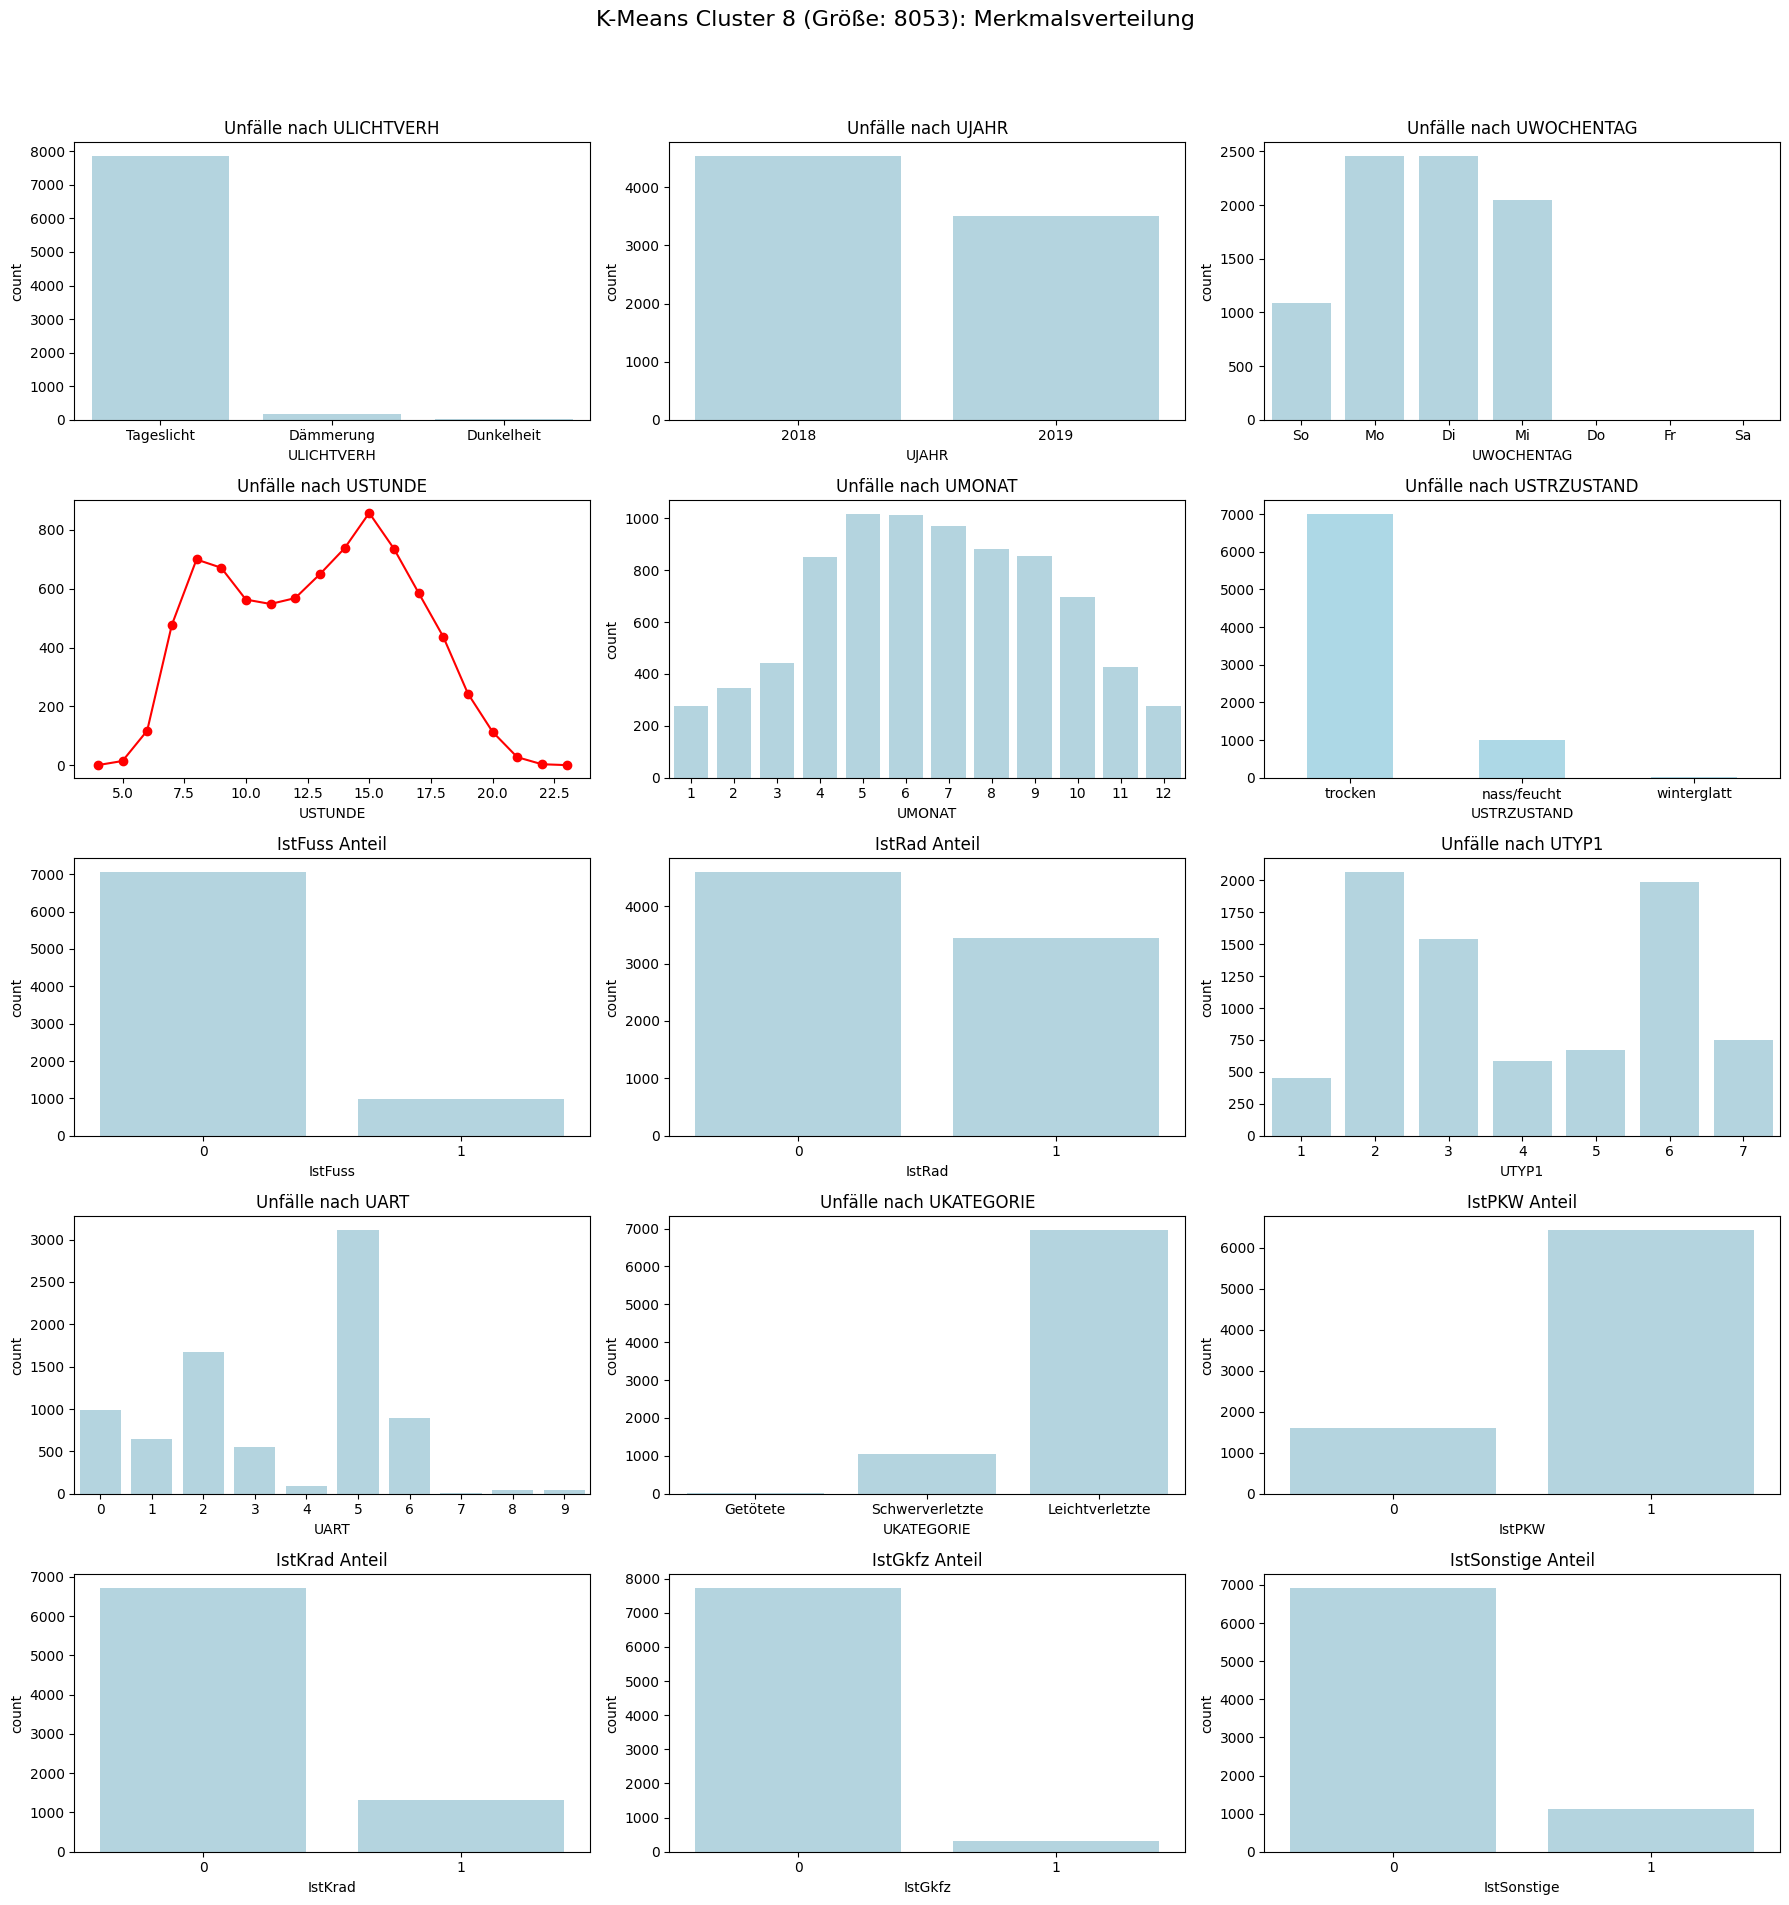

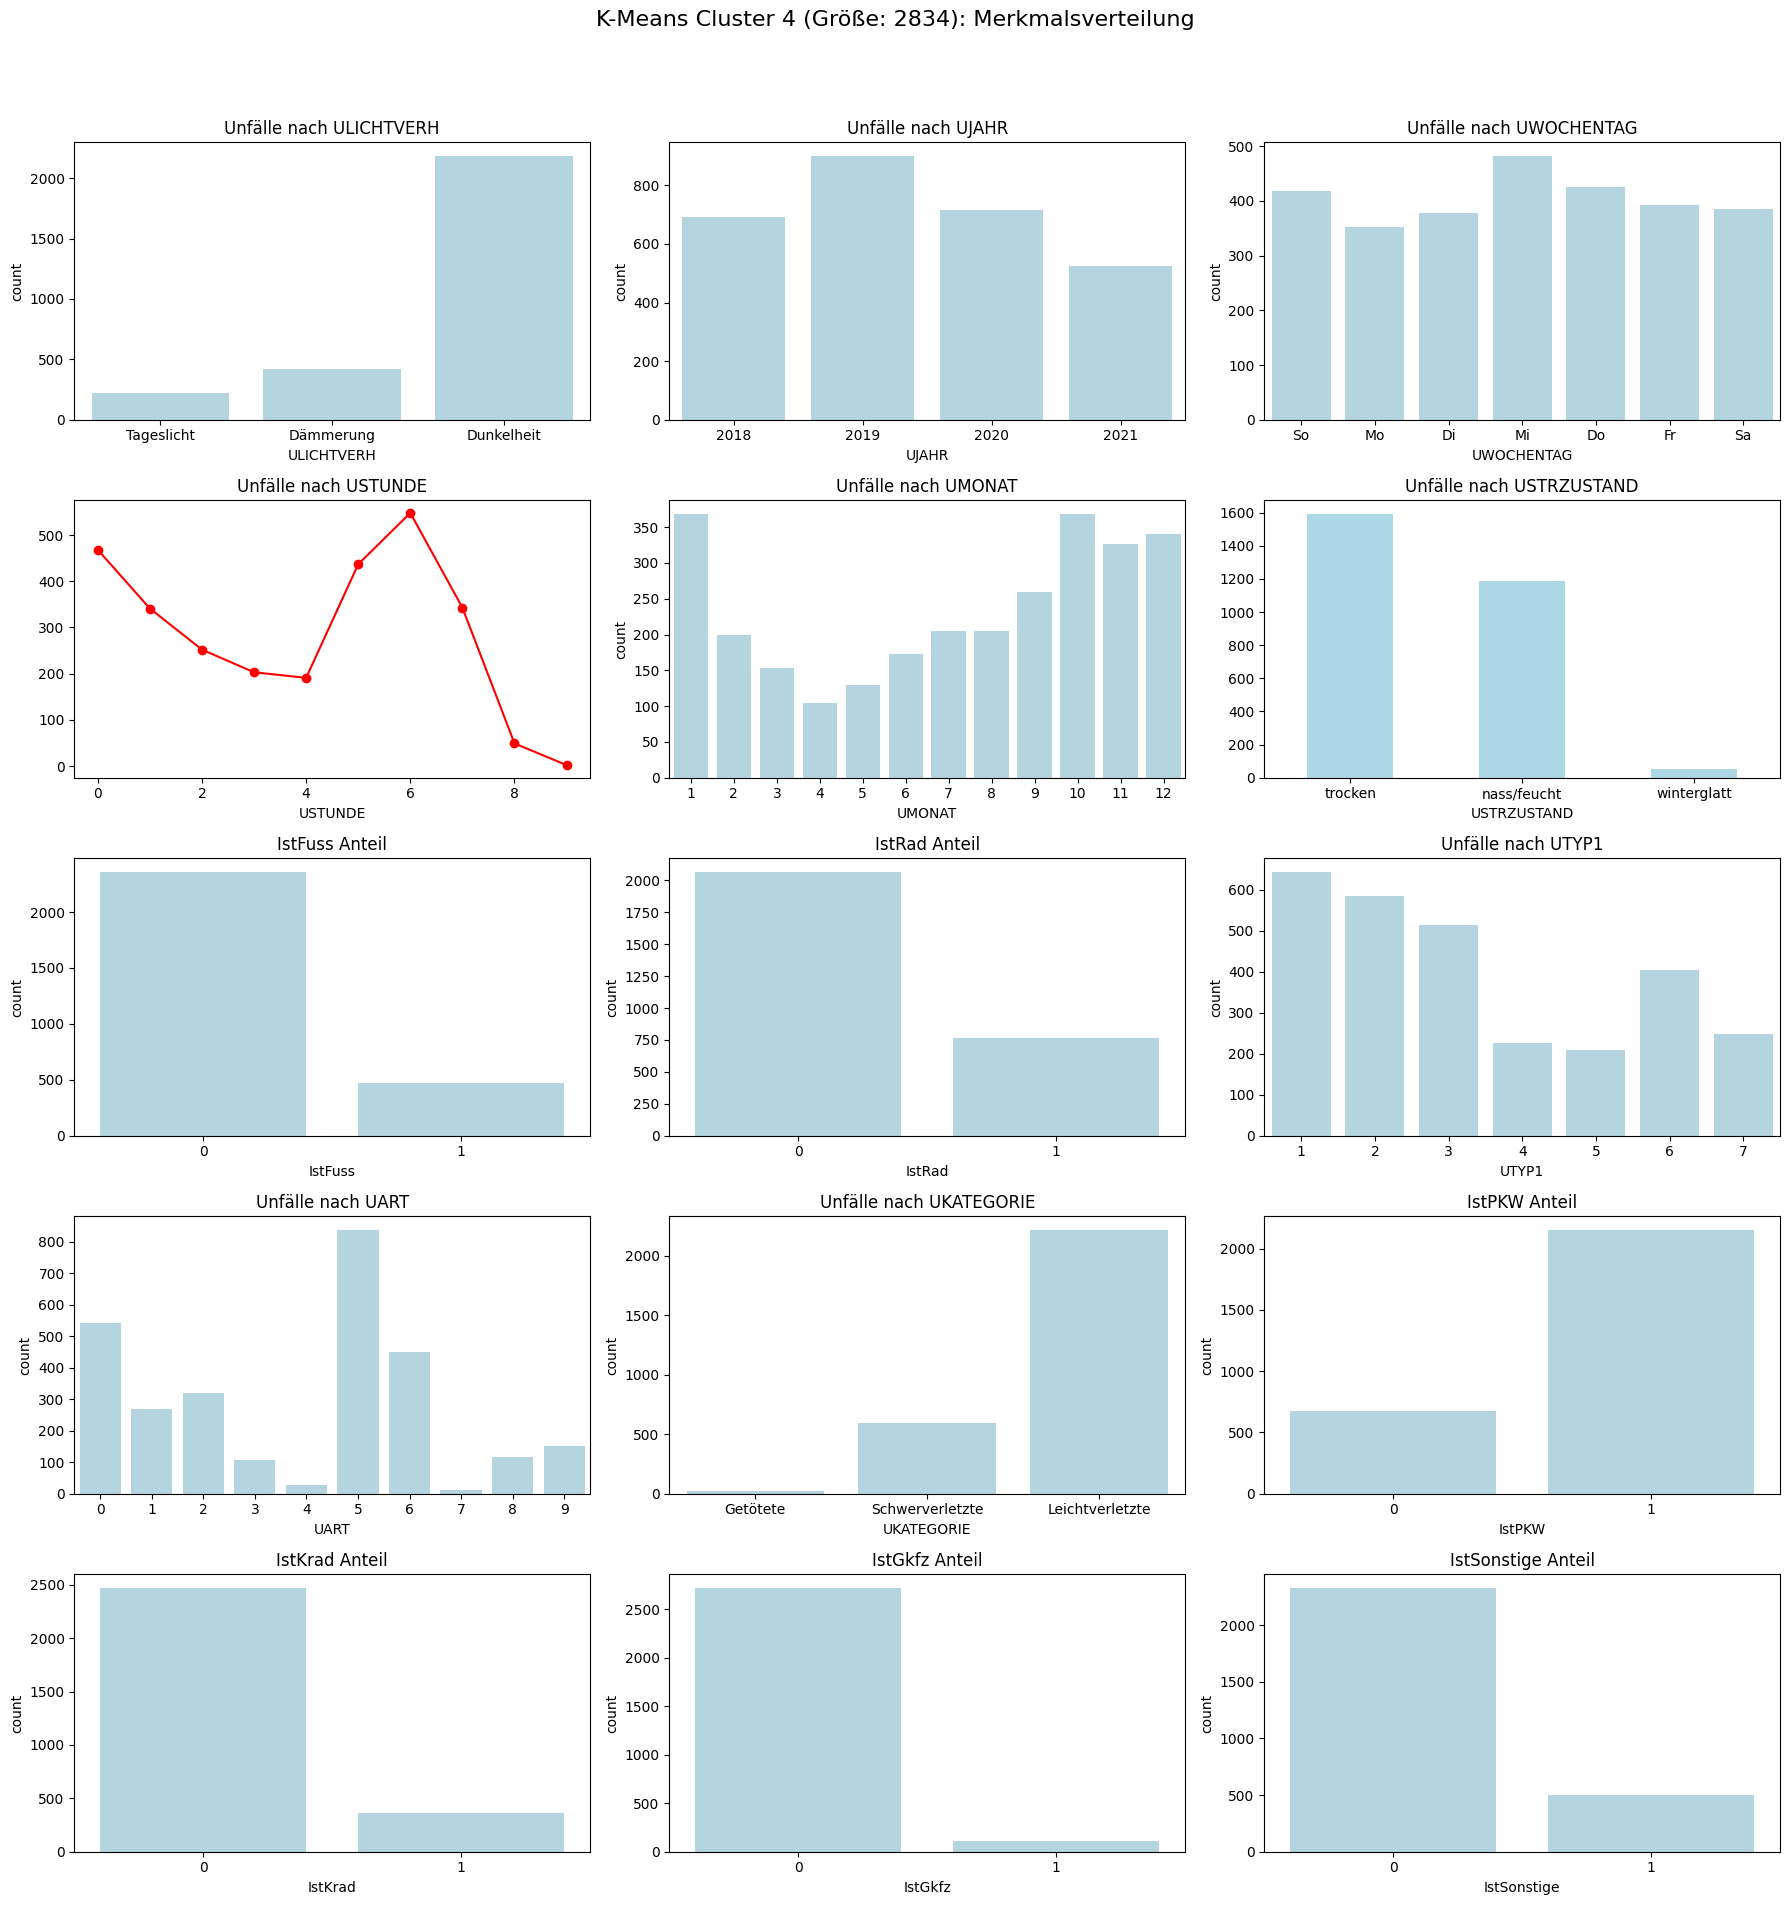

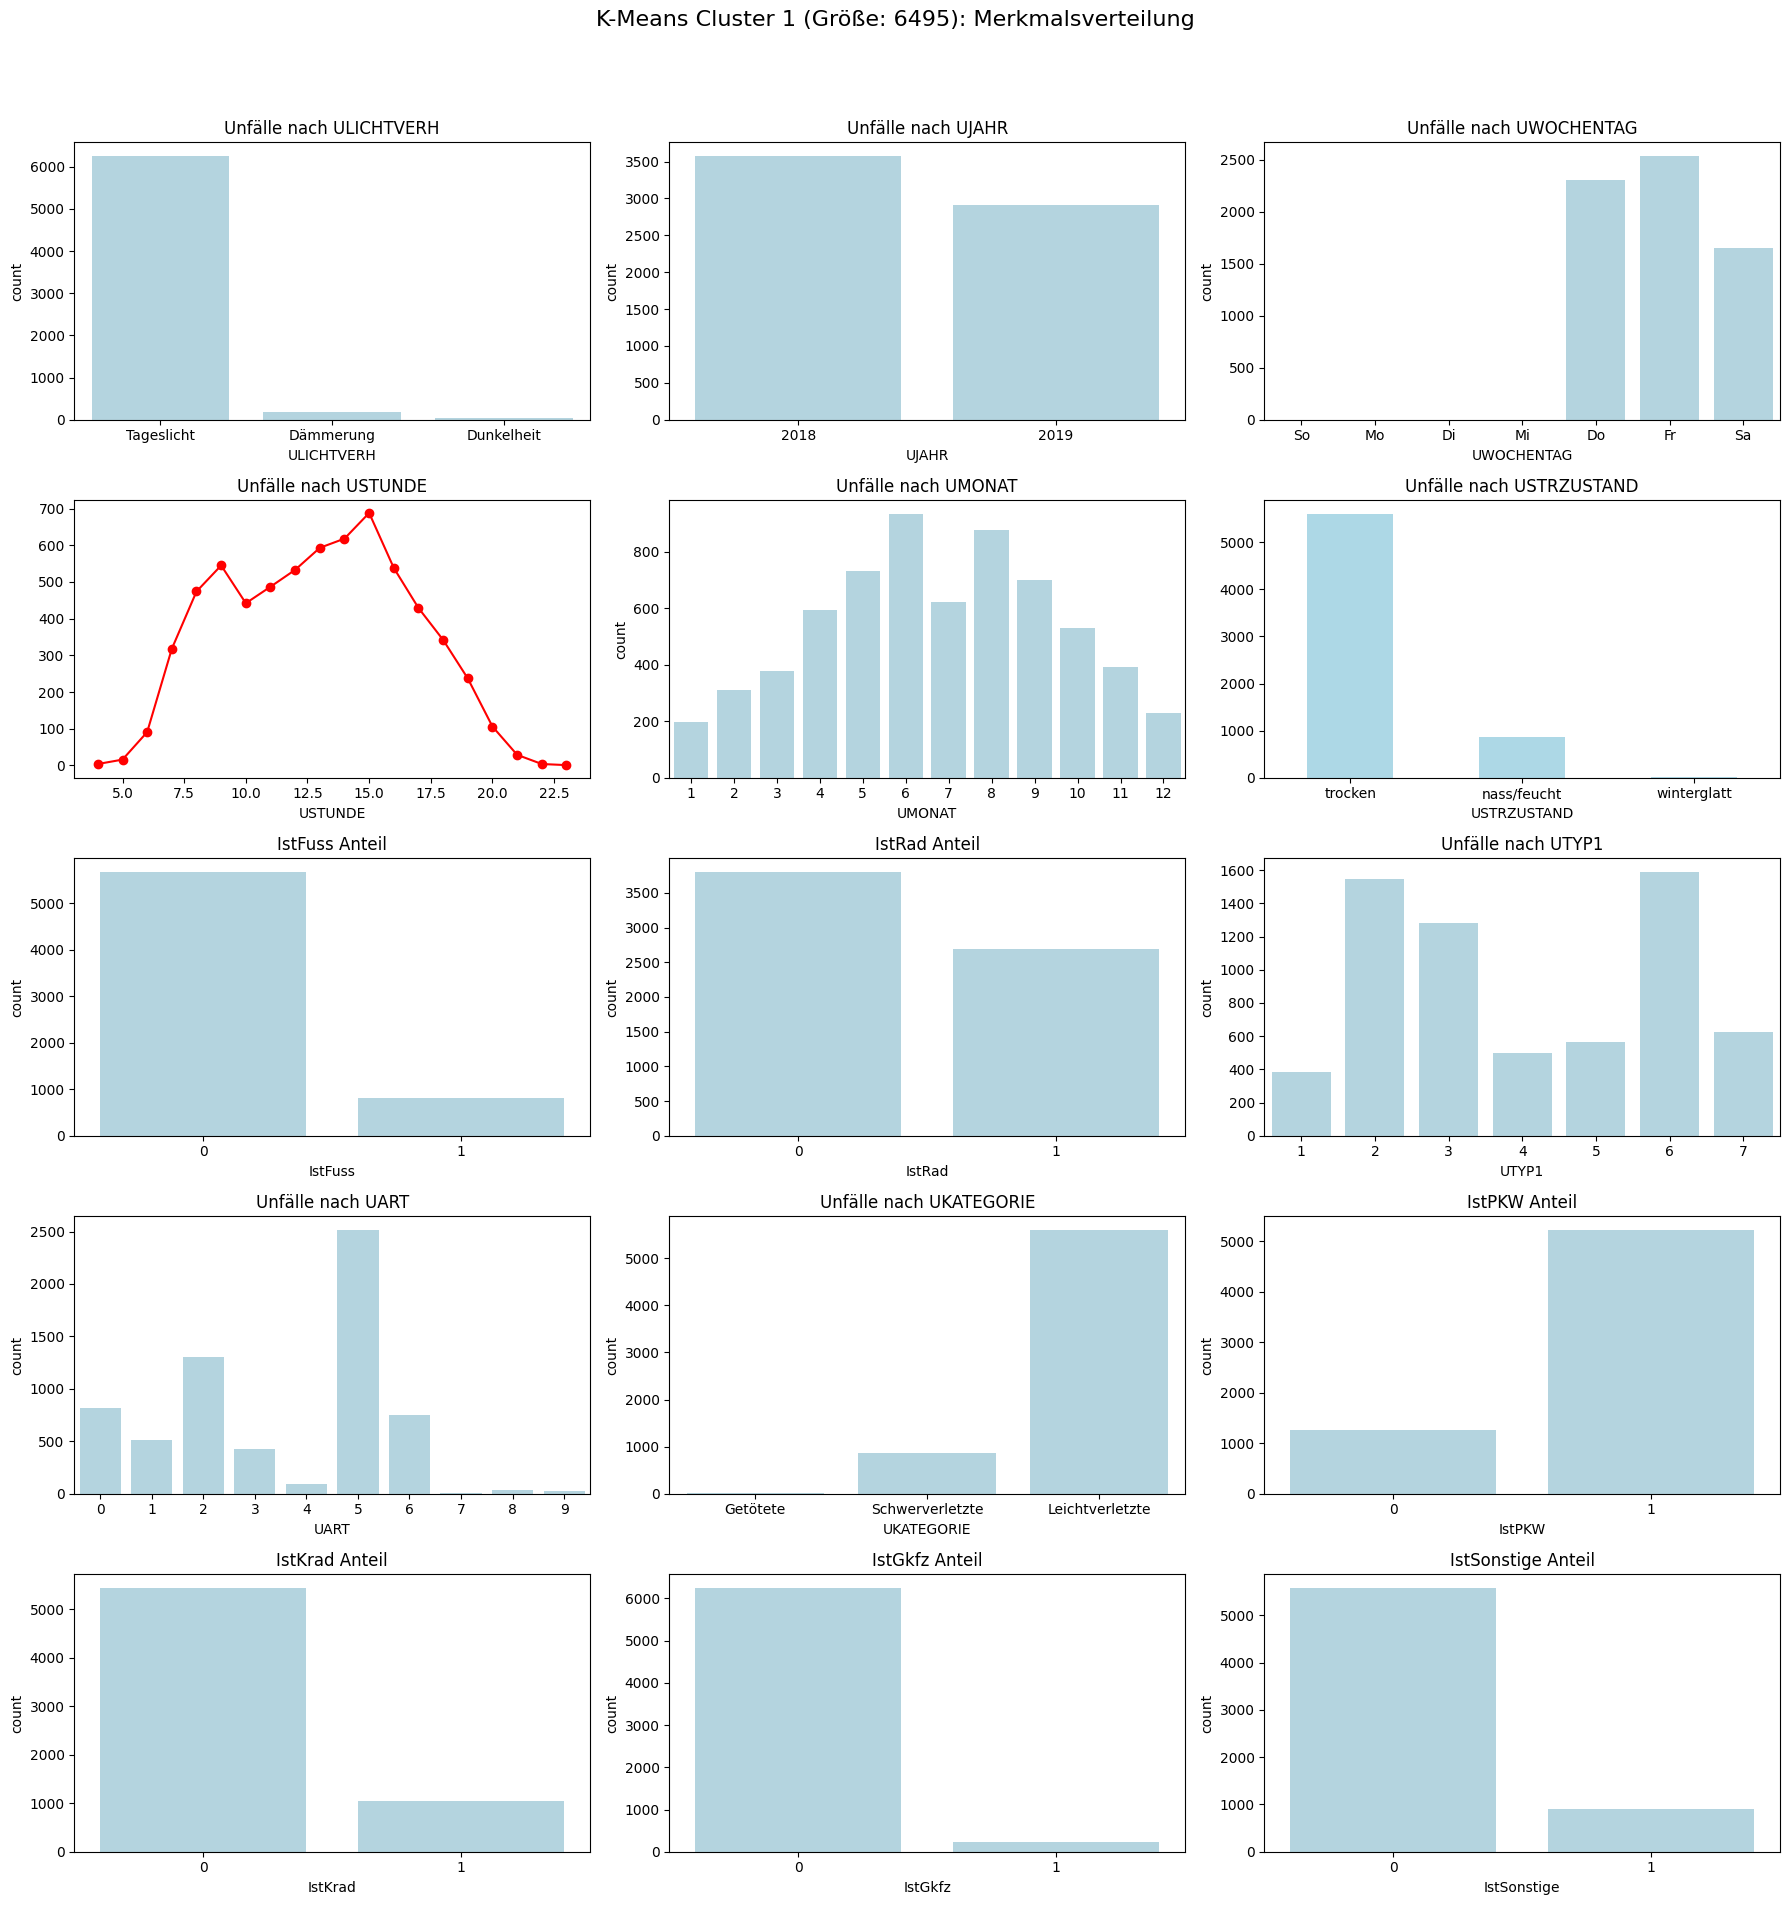

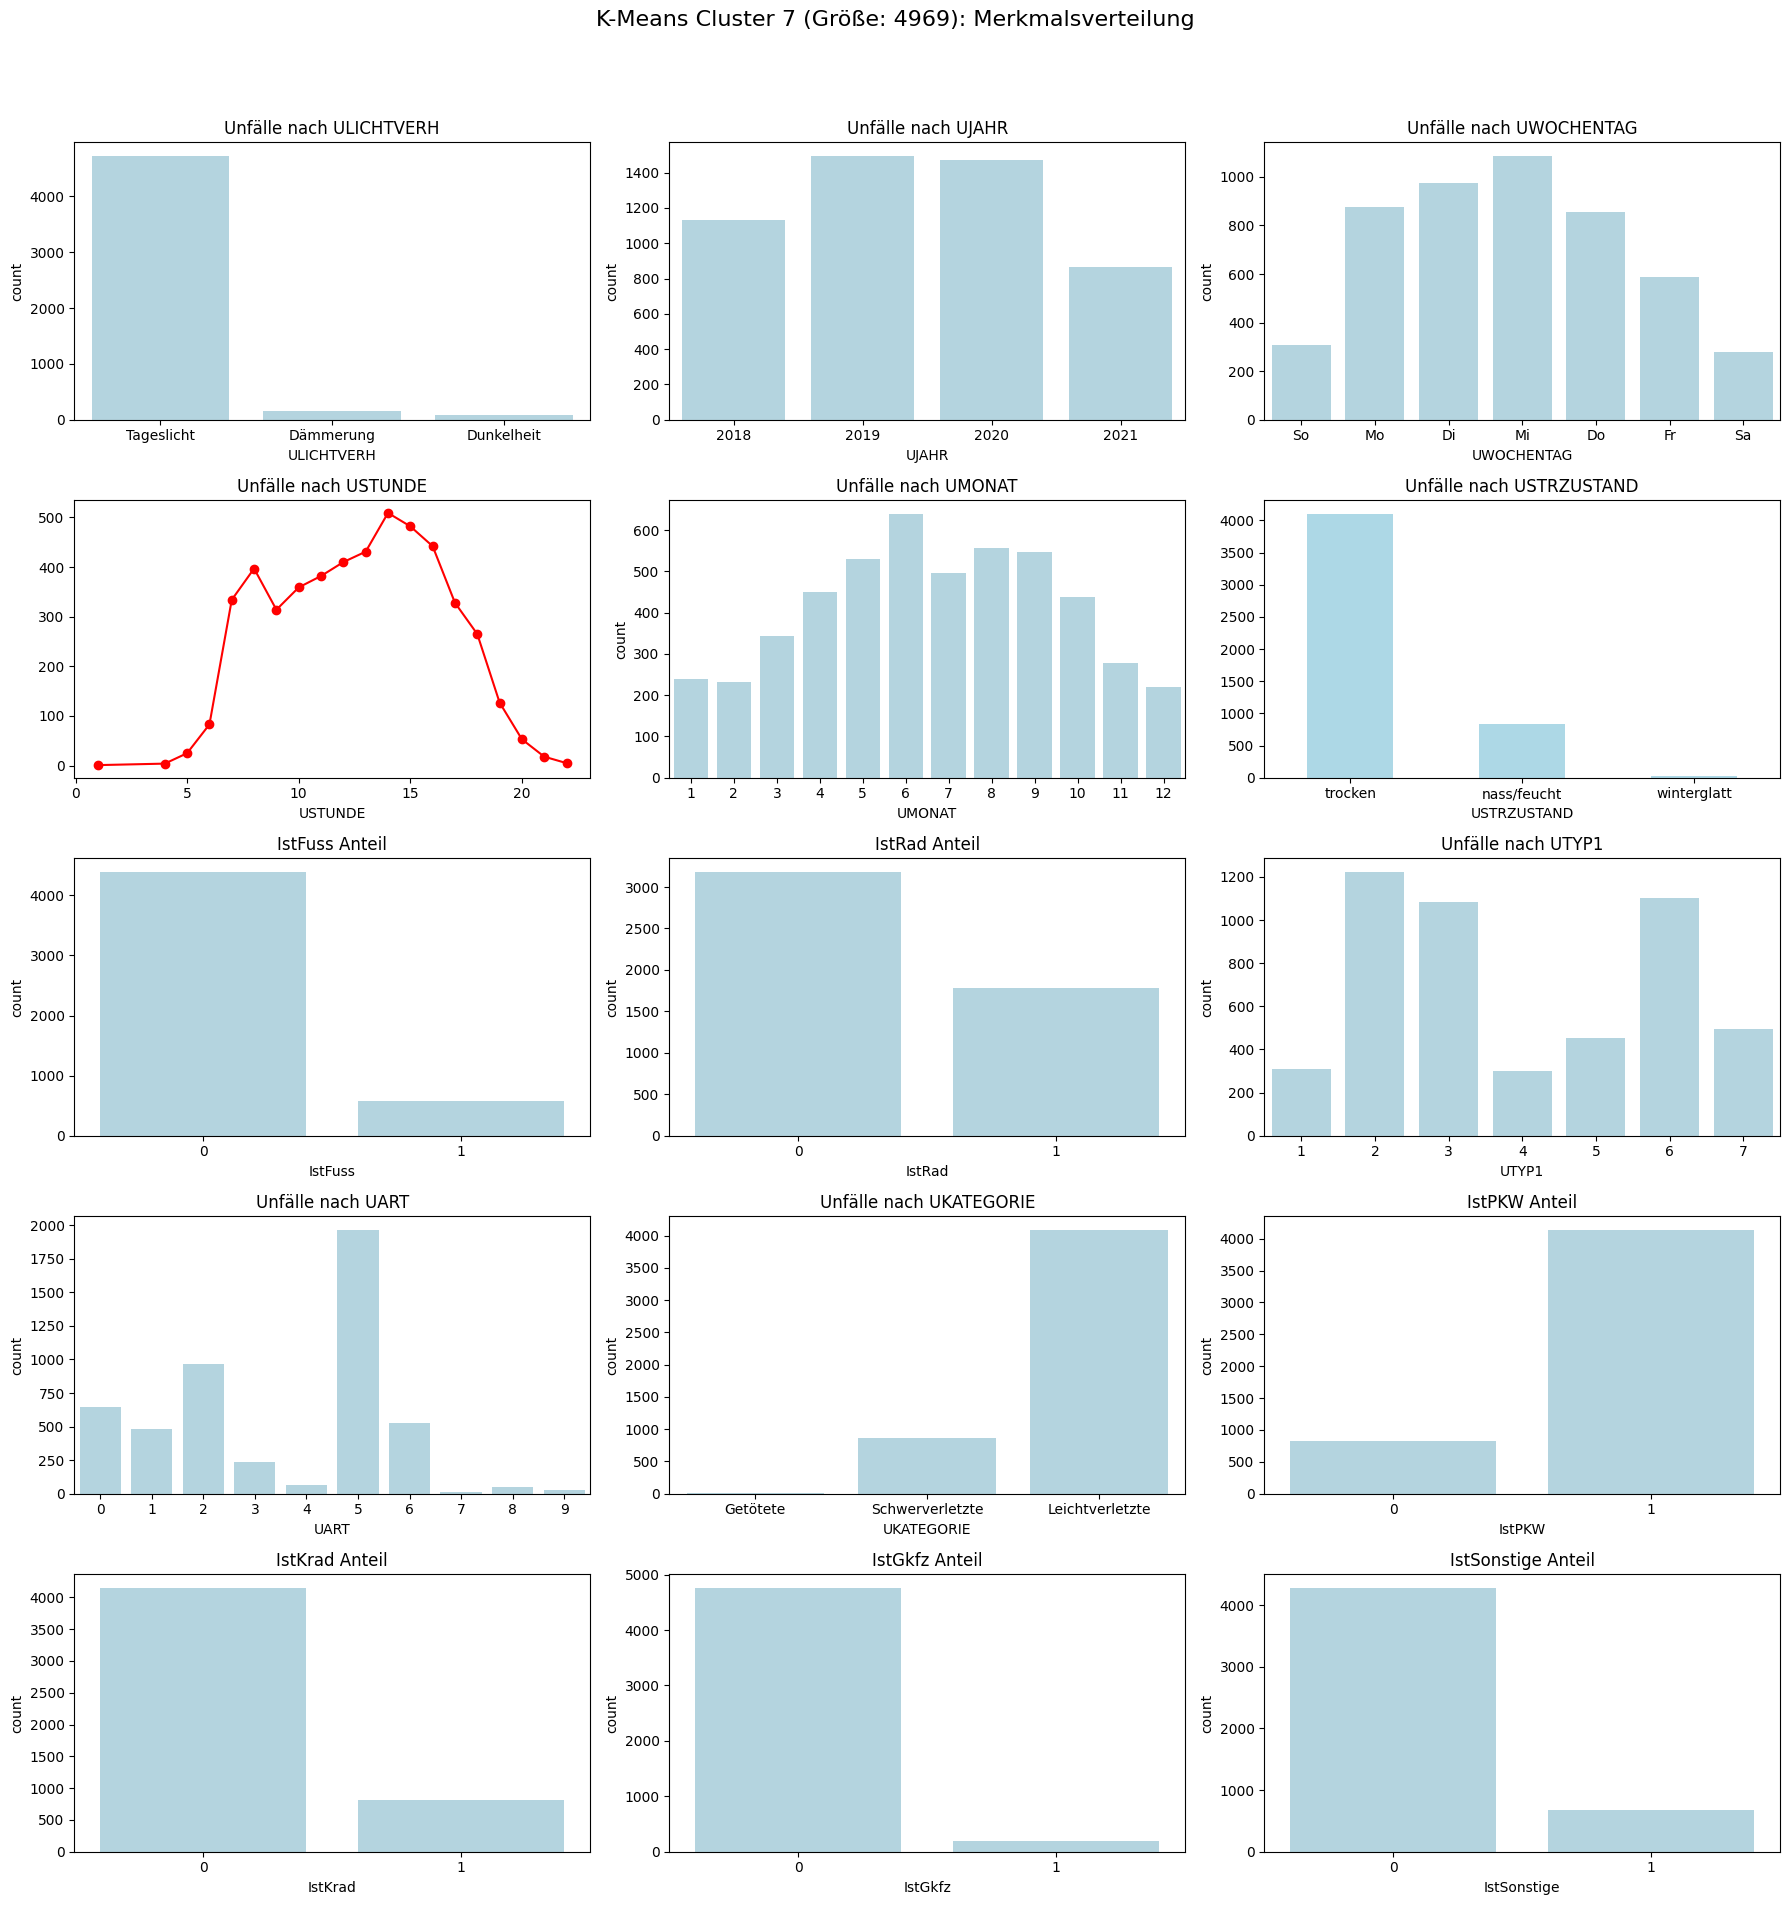

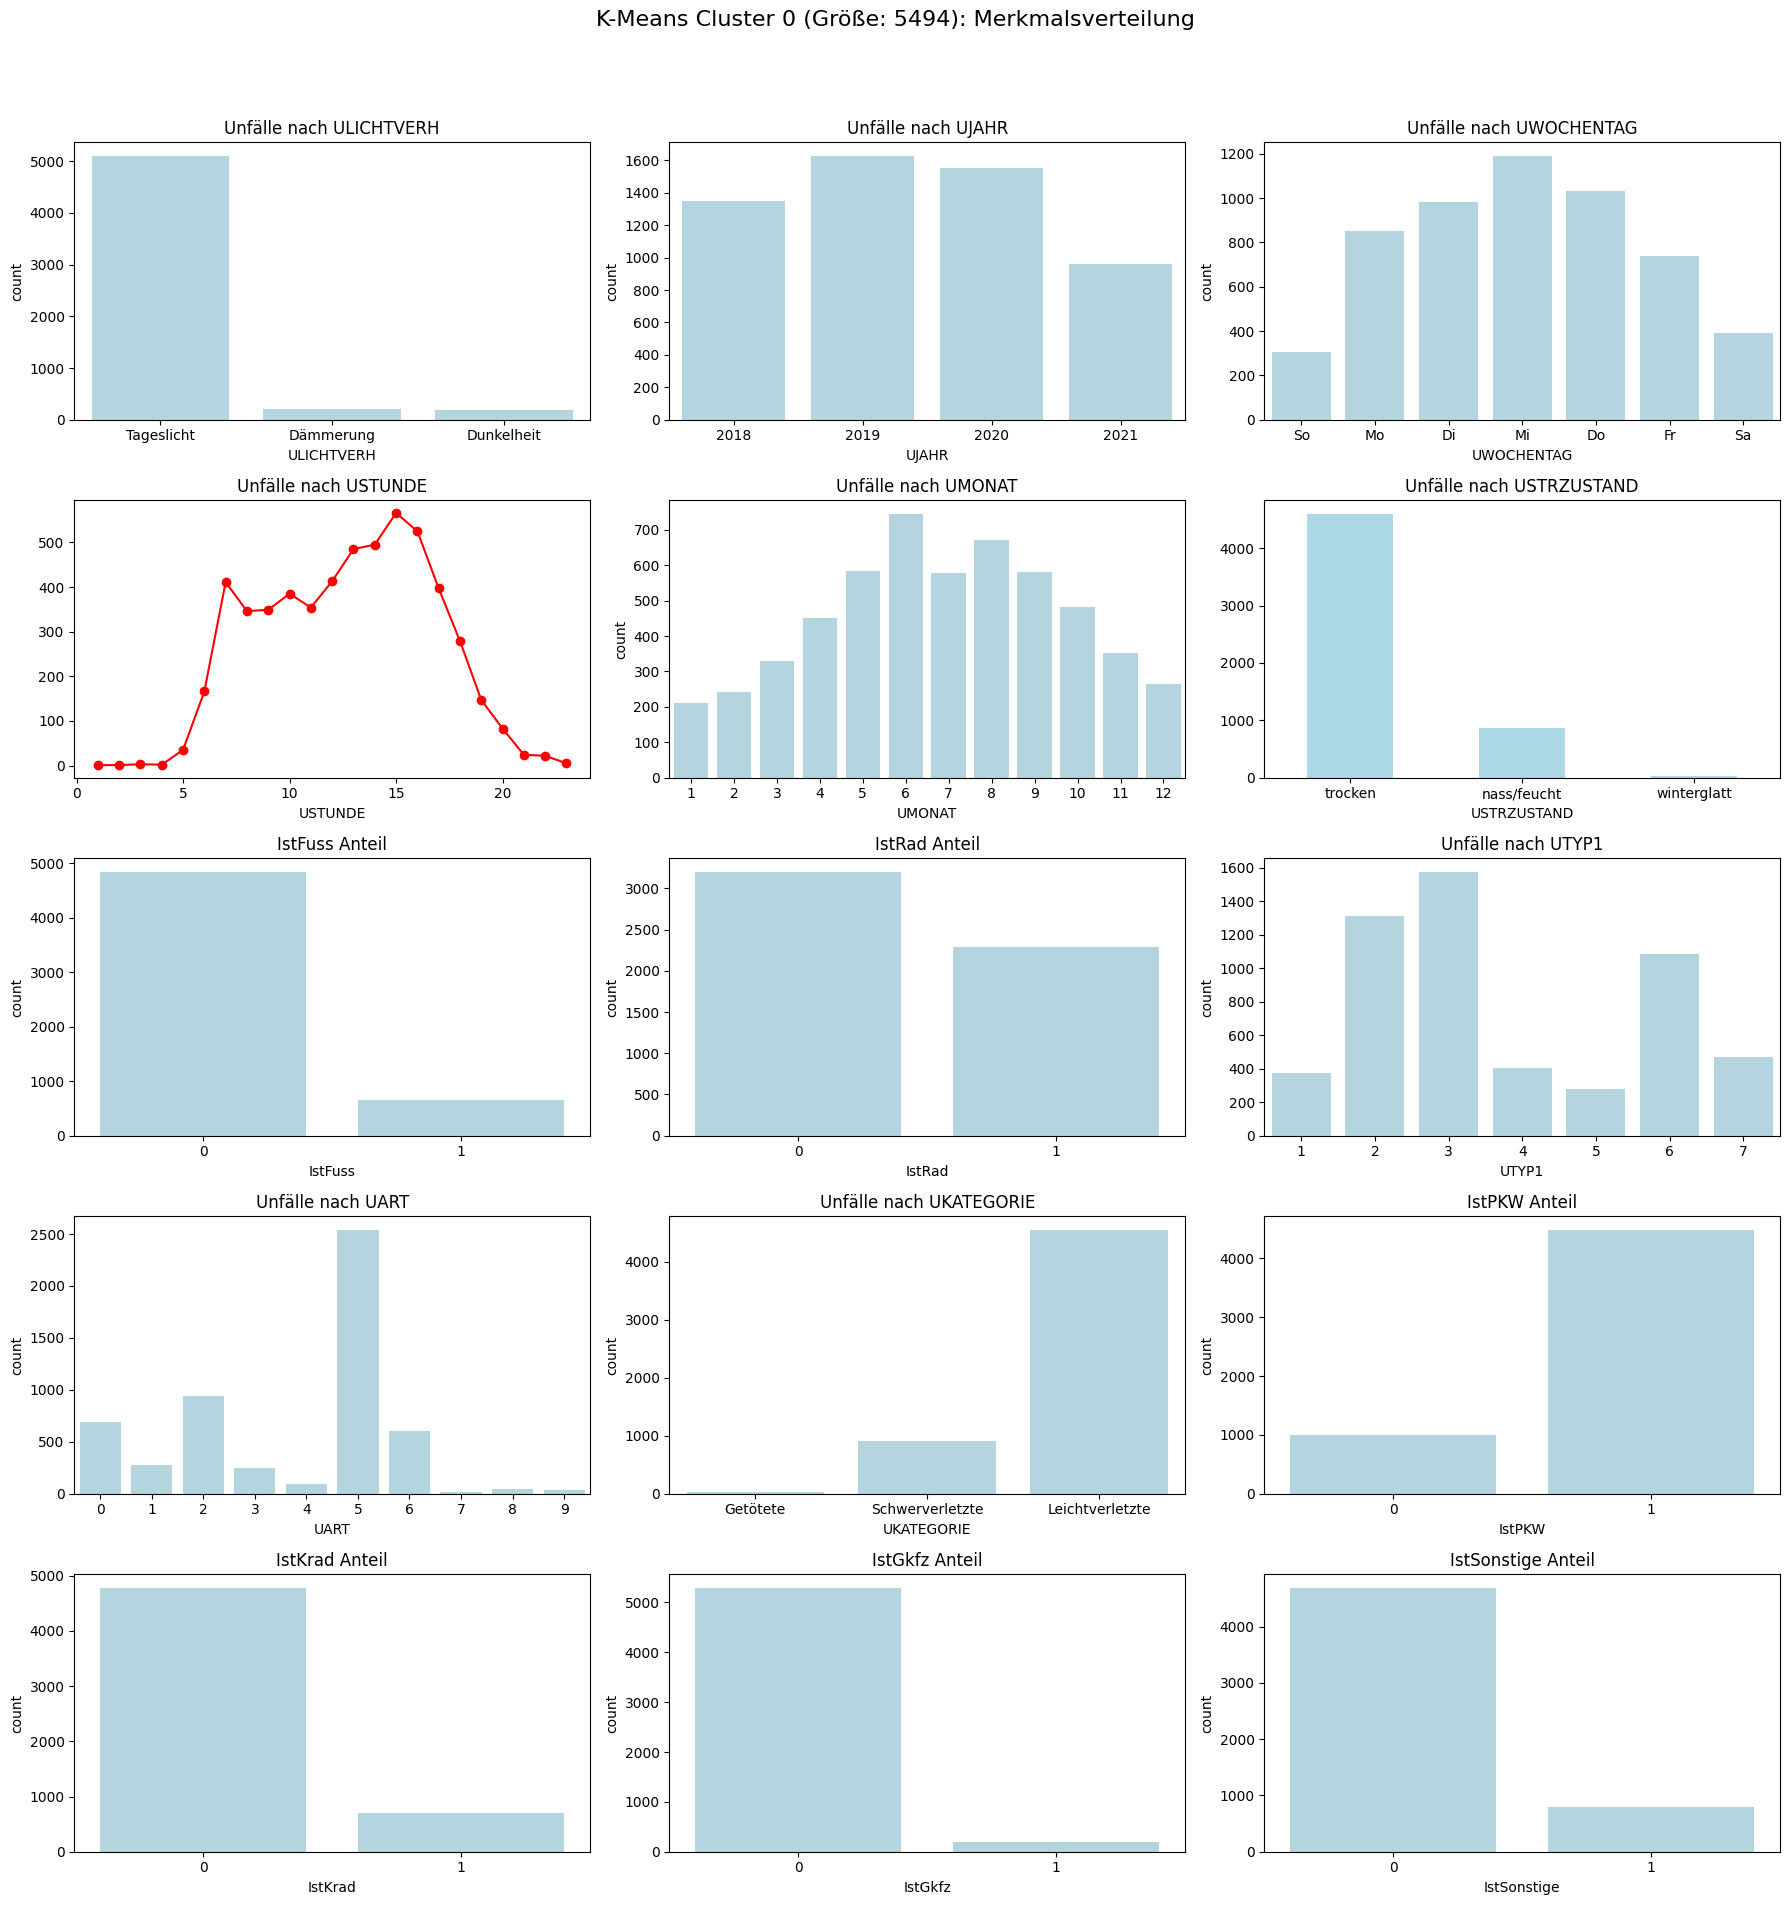

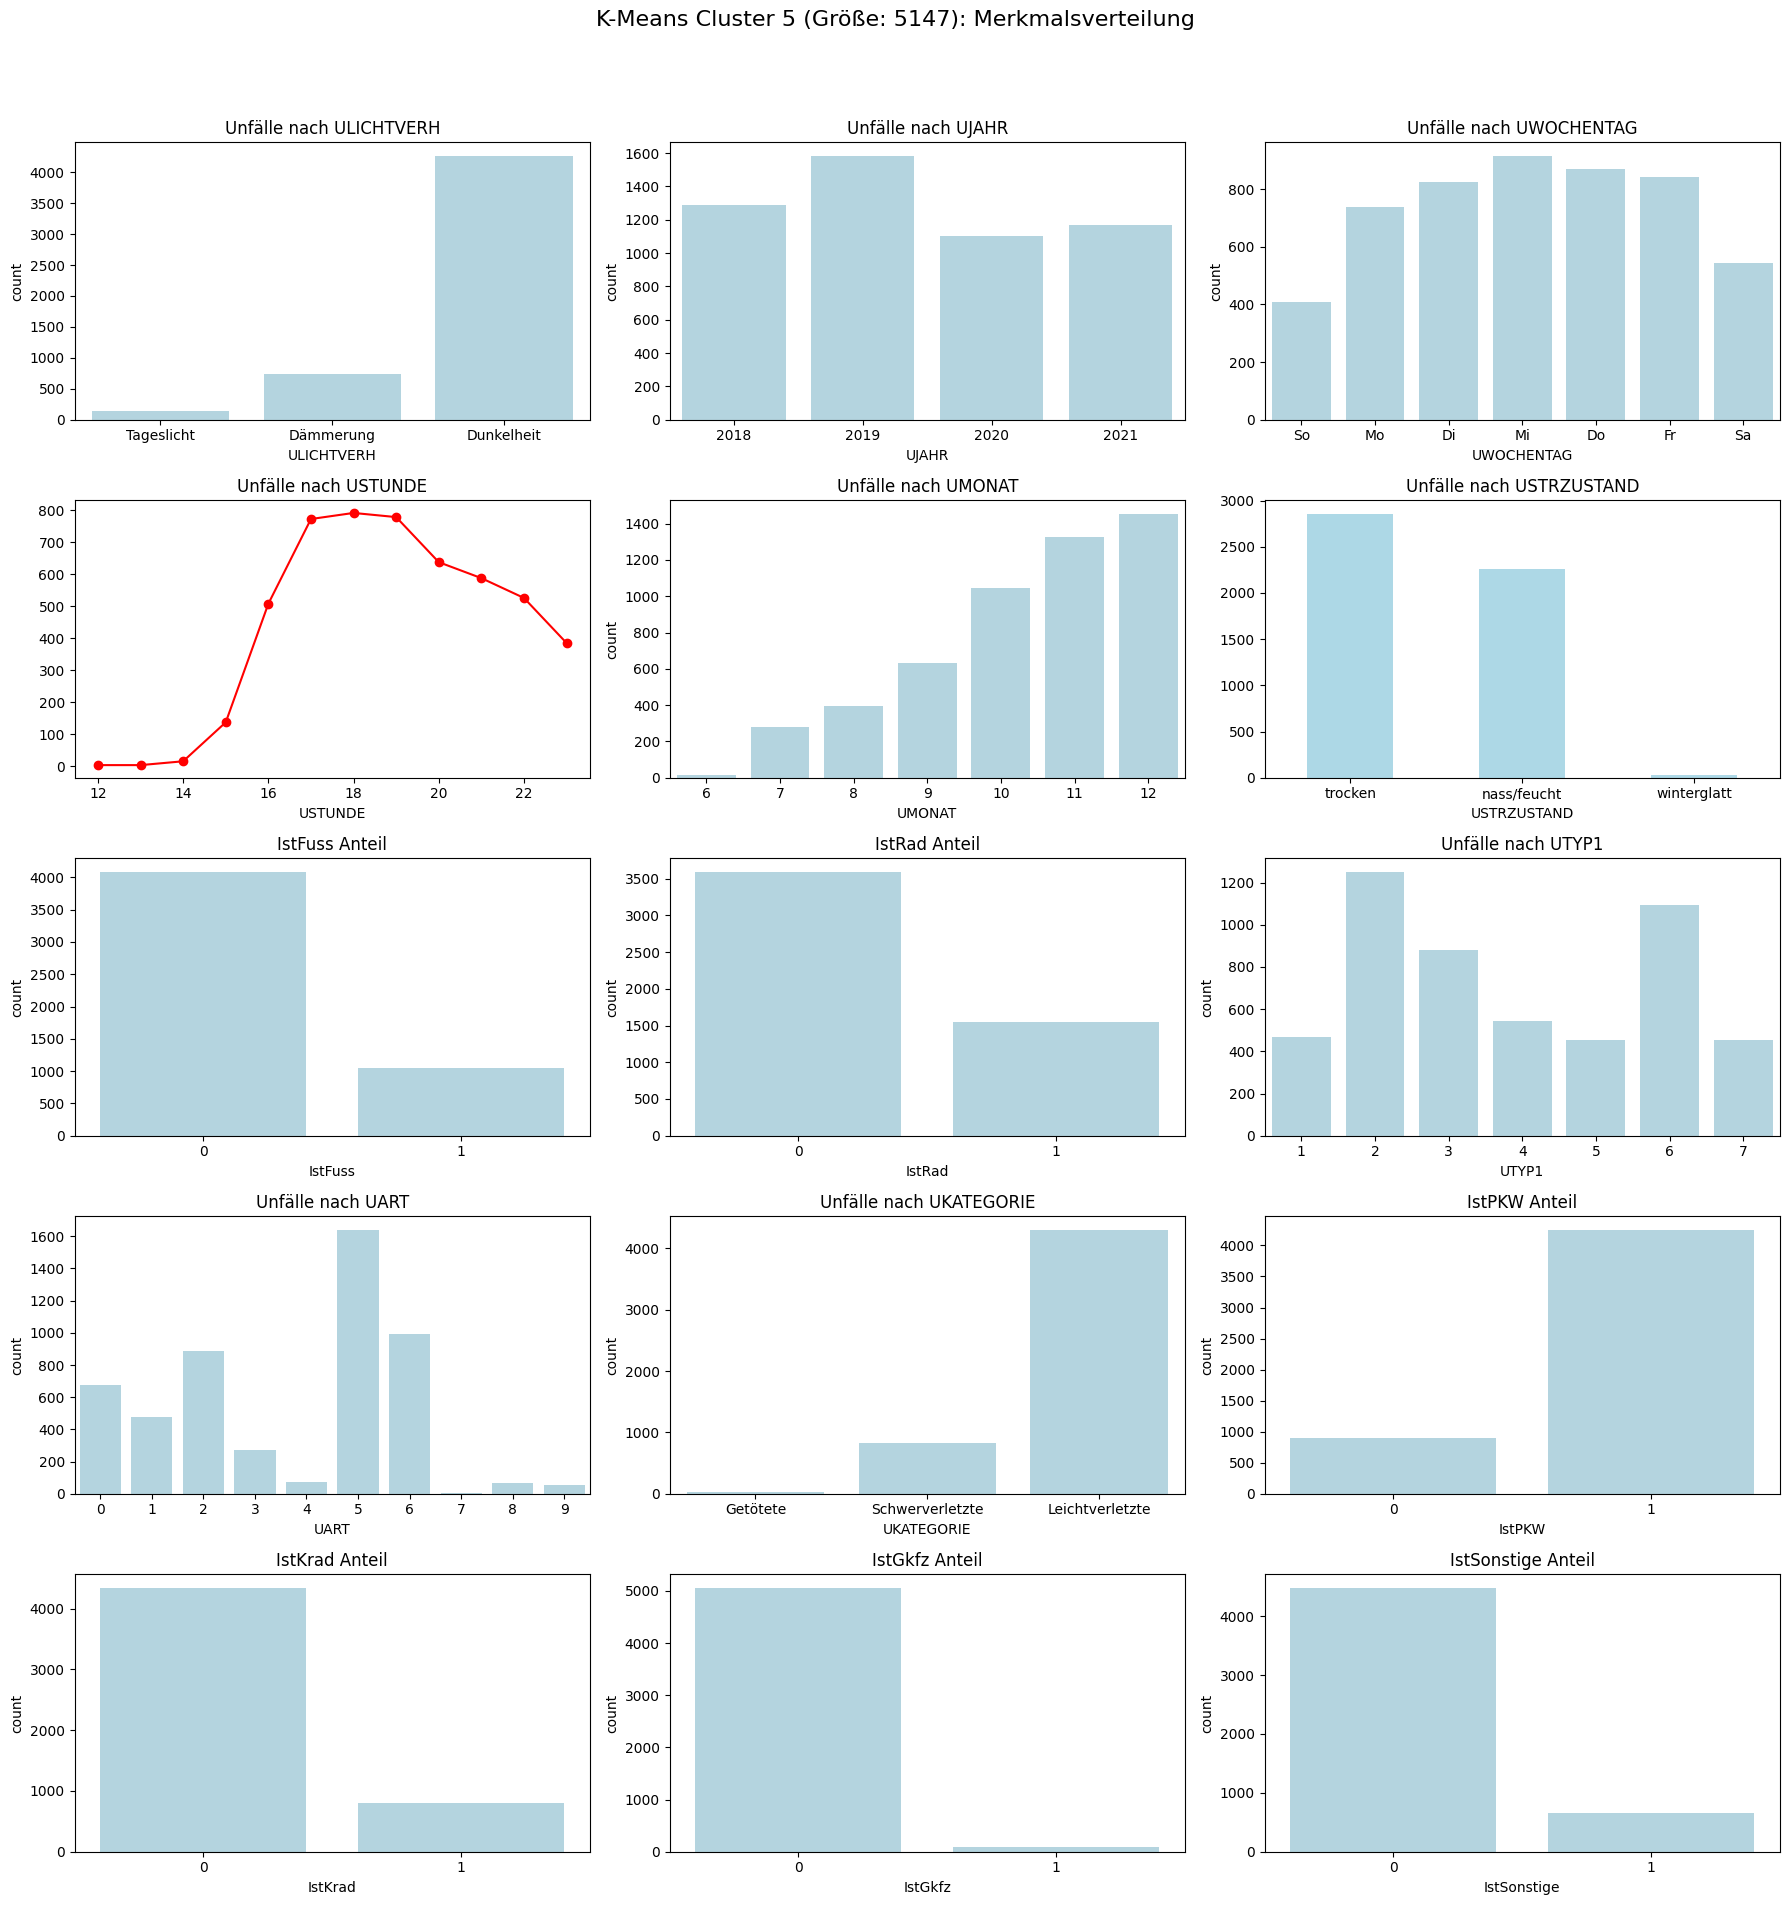

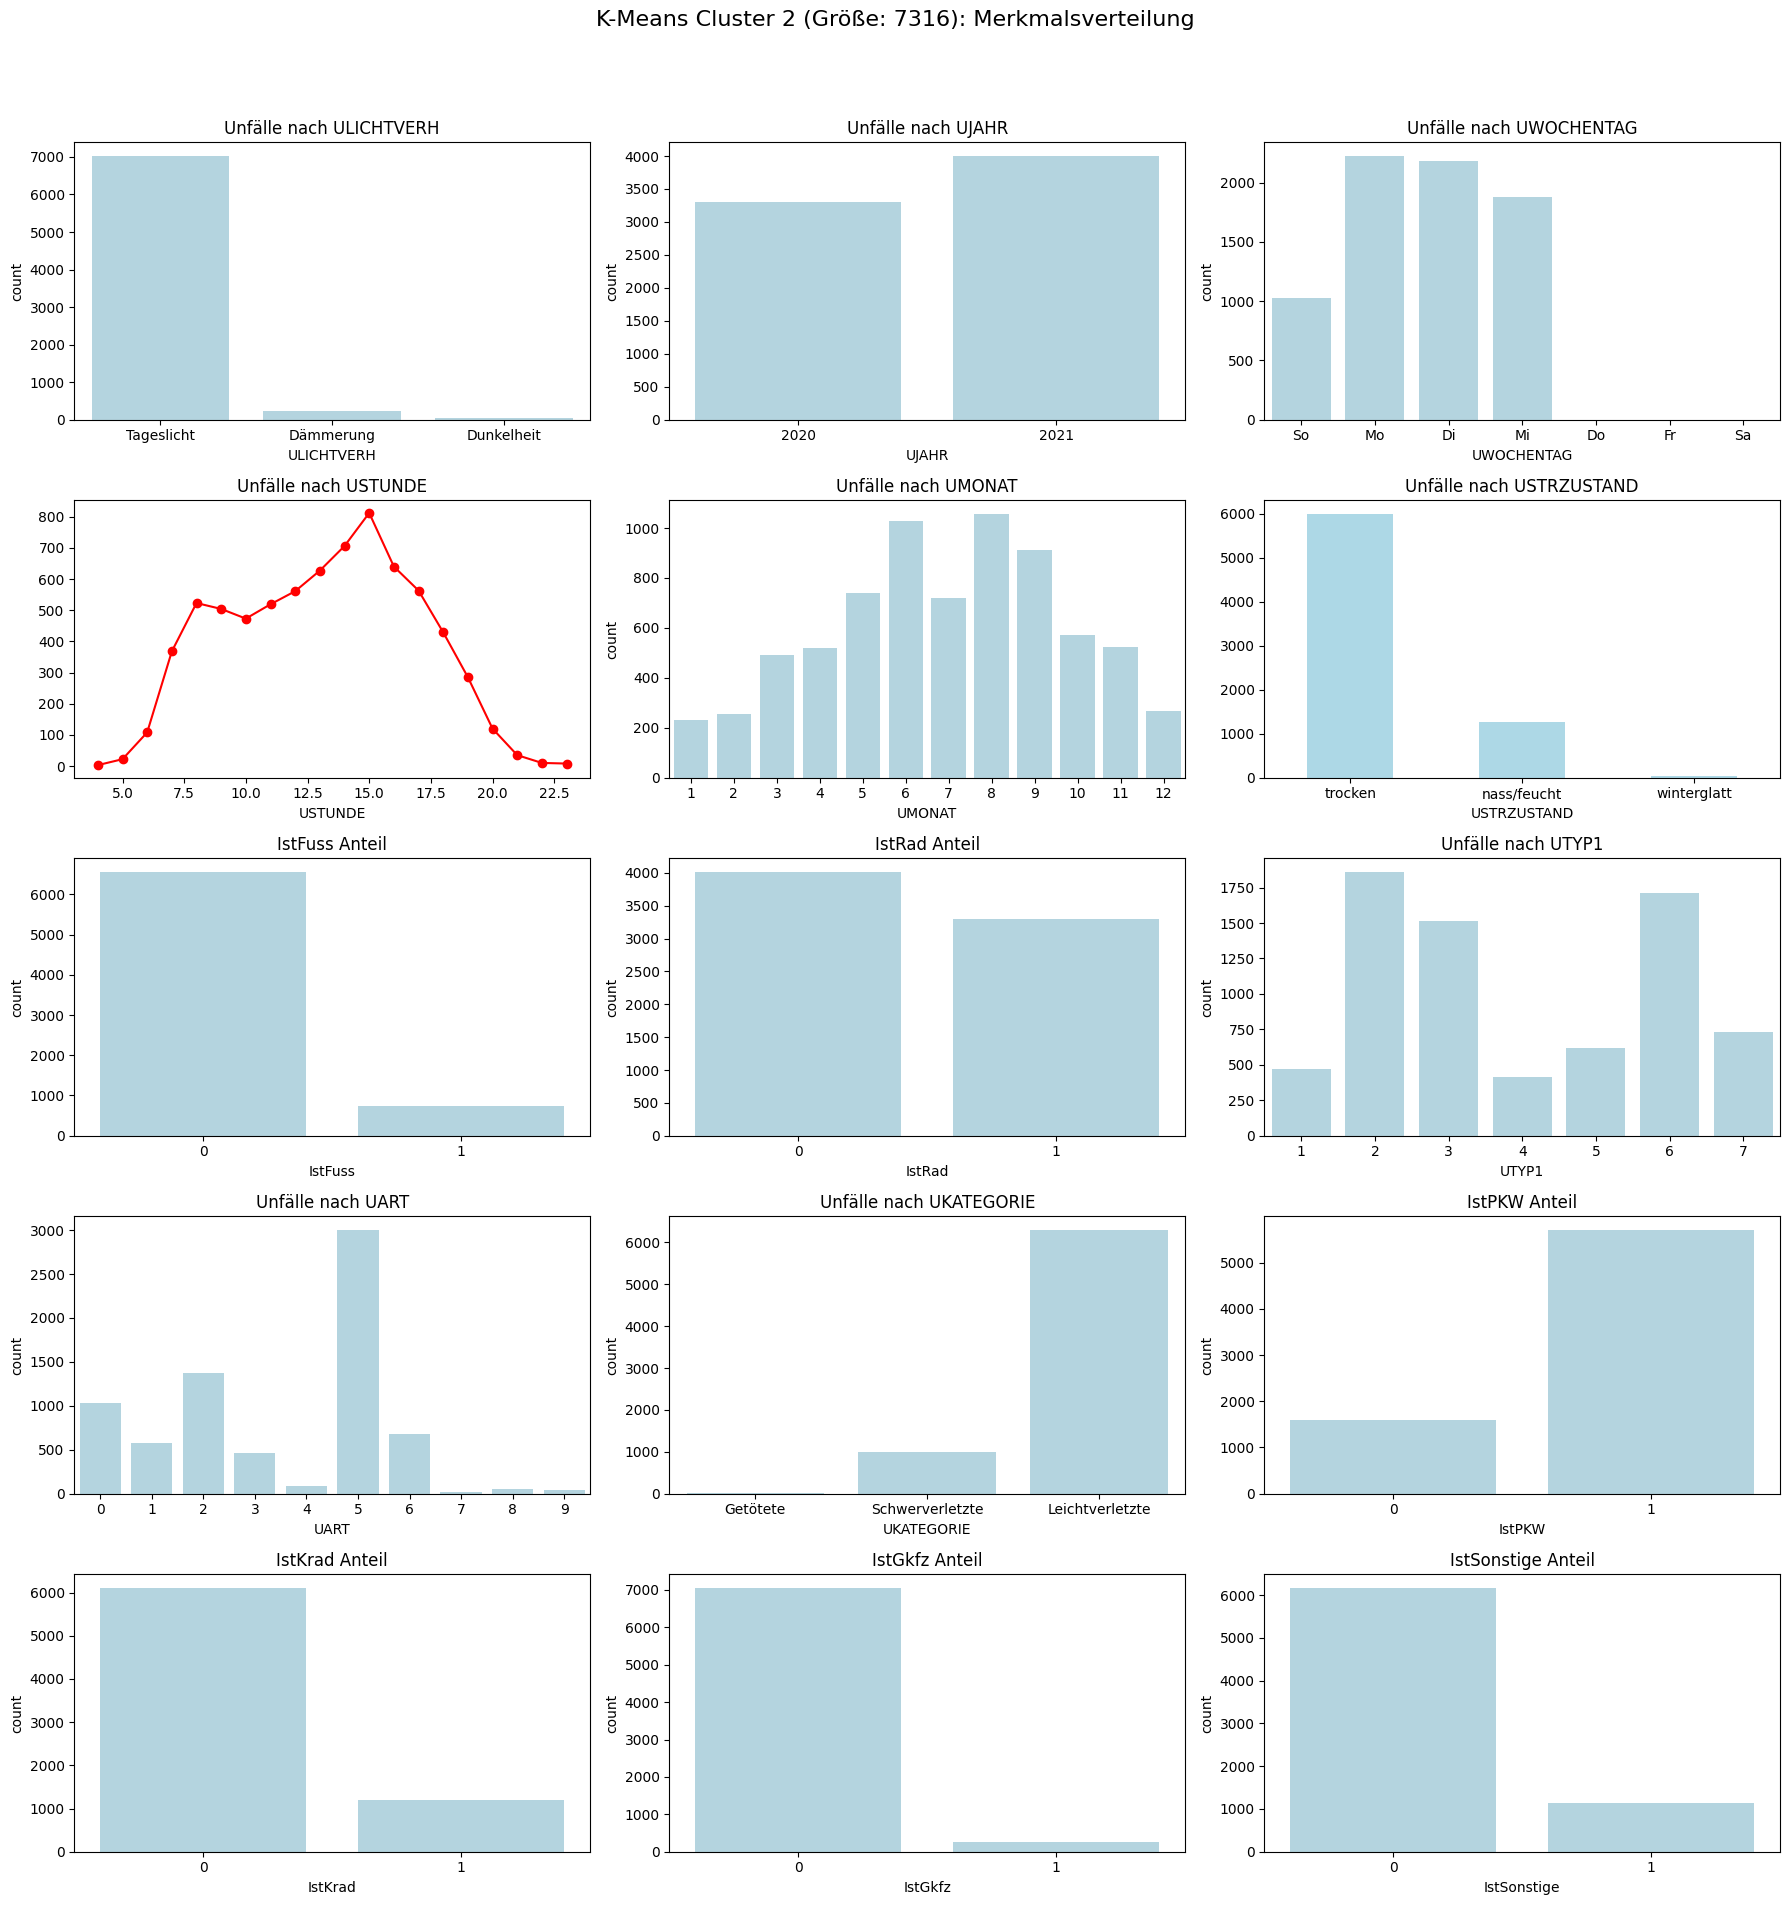

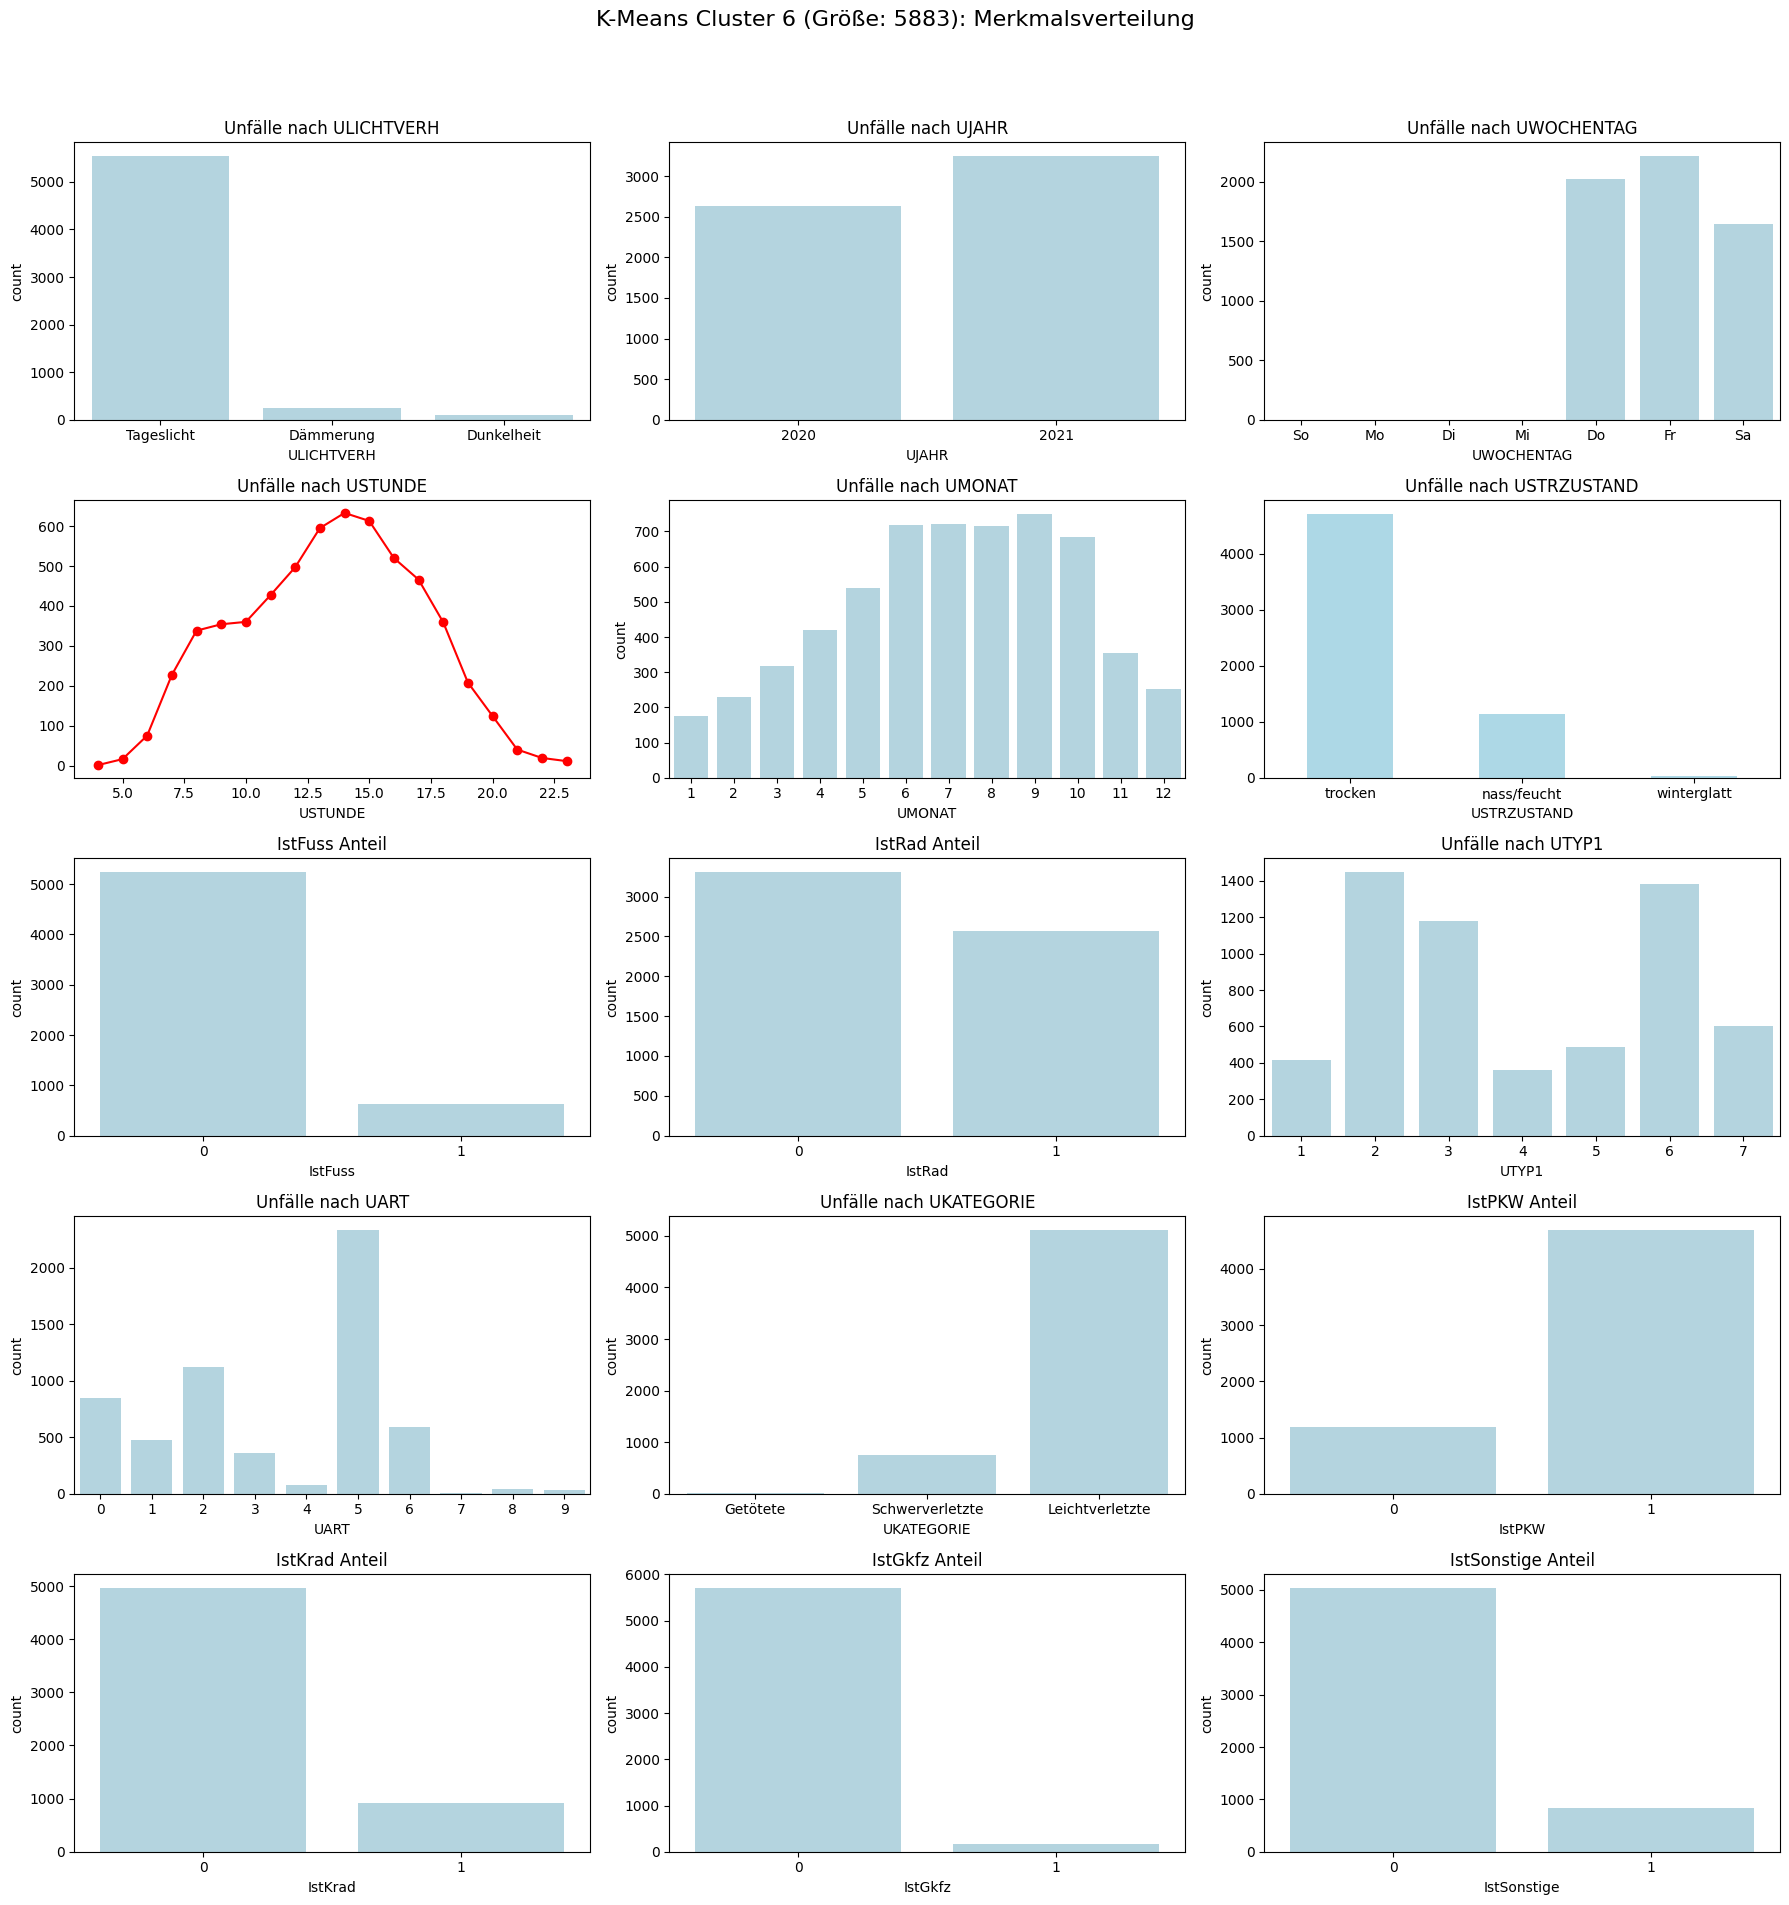

In [6]:

# -*- coding: utf-8 -*-
"""
KMeans-Clusteranalyse: Rücktransformation, Visualisierung der Clusterverteilungen und tabellarische Zusammenfassung
"""

# -------------------------------------------
#  Bibliotheken importieren
# -------------------------------------------
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

# -------------------------------------------
# 1. Daten und Modelle laden
# -------------------------------------------

# Lade Kruskal-Wallis-Ergebnisse zur Identifikation signifikanter Merkmale
kruskal_df = pd.read_csv("Kruskal-Wallis_results.csv")

# Lade transformierte Daten
df_encoded = pd.read_csv("k_means_ohneBEZ_LOR_encoded_data.csv")

# Lade KMeans-Modell
kmeans = joblib.load('kmeans_model.pkl')

# Weist jedem Datenpunkt das Cluster-Label zu
df_encoded['Cluster_Original'] = kmeans.predict(df_encoded.drop(columns=['Cluster_Original'], errors='ignore'))

# Filtere signifikante Features (p < 0.05) basierend auf Kruskal-Wallis-Test
significant_features = kruskal_df[kruskal_df['p-value'] < 0.05].sort_values(by='H-statistic', ascending=False)

# Lade Skalierungs- und Encodierungsobjekte zur Rücktransformation
std_scaler = joblib.load("k_means_std_scaler.pkl")
onehot_encoder = joblib.load("k_means_onehot_encoder.pkl")

# -------------------------------------------
# 2. Variablen definieren und rücktransformieren
# -------------------------------------------

numerical_vars = ['UJAHR', 'UMONAT', 'USTUNDE', 'UWOCHENTAG']
coordinate_vars = ['XGCSWGS84', 'YGCSWGS84']
ordinal_vars = ['UKATEGORIE']
nominal_vars = ['UART', 'UTYP1', 'ULICHTVERH', 'USTRZUSTAND']
binary_vars = ['IstRad', 'IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz', 'IstSonstige']
categorical_vars = nominal_vars + ordinal_vars

# Rücktransformation der skalierten numerischen und Koordinatenvariablen
df_encoded[numerical_vars + coordinate_vars] = std_scaler.inverse_transform(df_encoded[numerical_vars + coordinate_vars])

# Rücktransformation des One-Hot-Encodings für nominale Variablen
onehot_columns = onehot_encoder.get_feature_names_out(nominal_vars)
df_nominal = pd.DataFrame(onehot_encoder.inverse_transform(df_encoded[onehot_columns]), columns=nominal_vars)

# Mapping für bessere Lesbarkeit
licht_map = {0: "Tageslicht", 1: "Dämmerung", 2: "Dunkelheit"}
df_nominal['ULICHTVERH'] = df_nominal['ULICHTVERH'].map(licht_map)

# One-Hot-Spalten ersetzen
df_encoded = df_encoded.drop(columns=onehot_columns)
df_encoded = pd.concat([df_encoded, df_nominal], axis=1)

# -------------------------------------------
# 3. Cluster-Statistiken und Visualisierung vorbereiten
# -------------------------------------------

# Koordinaten aus signifikanten Merkmalen ausschließen
exclude_coordinates = ['XGCSWGS84', 'YGCSWGS84']
significant_features_list = significant_features['Feature'].tolist()
filtered_features = [f for f in significant_features_list if f not in exclude_coordinates]
binary_features = binary_vars

cluster_counts = df_encoded['Cluster_Original'].value_counts().sort_index()
num_clusters = df_encoded['Cluster_Original'].nunique()

# Mapping-Werte
wochentag_map = {1: "So", 2: "Mo", 3: "Di", 4: "Mi", 5: "Do", 6: "Fr", 7: "Sa"}
ukategorie_map = {1: "Getötete", 2: "Schwerverletzte", 3: "Leichtverletzte"}

# Mapping und Sortierung anwenden
df_encoded['ULICHTVERH'] = pd.Categorical(df_encoded['ULICHTVERH'], categories=["Tageslicht", "Dämmerung", "Dunkelheit"], ordered=True)
df_encoded['UWOCHENTAG'] = pd.Categorical(df_encoded['UWOCHENTAG'], categories=[1,2,3,4,5,6,7], ordered=True).map(wochentag_map)
df_encoded['UKATEGORIE'] = df_encoded['UKATEGORIE'].map(ukategorie_map)

# -------------------------------------------
# 4. Clusterweise Visualisierung
# -------------------------------------------

for cluster in df_encoded['Cluster_Original'].unique():
    df_cluster = df_encoded[df_encoded['Cluster_Original'] == cluster].copy()

    if df_cluster.empty:
        continue

    df_cluster['UJAHR'] = df_cluster['UJAHR'].astype(int)
    df_cluster['UMONAT'] = df_cluster['UMONAT'].astype(int)

    plots = []
    for feature in filtered_features:
        if feature in df_cluster.columns and not df_cluster[feature].isna().all():
            if feature in binary_features:
                plots.append((feature, '#ADD8E6', f'{feature} Anteil'))
            else:
                plots.append((feature, '#ADD8E6', f'Unfälle nach {feature}'))

    n_plots = len(plots)
    n_cols = 3
    n_rows = int(np.ceil(n_plots / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    axes = axes.flatten()
    fig.suptitle(f'K-Means Cluster {cluster} (Größe: {cluster_counts[cluster]}): Merkmalsverteilung', fontsize=16)

    for i, (feature, color, title) in enumerate(plots):
        ax = axes[i]
        if feature == 'USTUNDE':
            df_cluster['USTUNDE'].value_counts().sort_index().plot(kind='line', ax=ax, color='red', marker='o')
        elif feature == 'USTRZUSTAND':
            ustrzustand_counts = df_cluster['USTRZUSTAND'].value_counts().sort_index().reindex([0, 1, 2], fill_value=0)
            ustrzustand_counts.plot(kind='bar', ax=ax, color=color)
            ax.set_xticks([0, 1, 2])
            ax.set_xticklabels(['trocken', 'nass/feucht', 'winterglatt'], rotation=0)
        elif feature == 'UWOCHENTAG':
            sns.countplot(x=feature, data=df_cluster, ax=ax, hue=feature, palette=[color]*7, order=["So", "Mo", "Di", "Mi", "Do", "Fr", "Sa"], dodge=False, legend=False)
            ax.set_title('Unfälle nach Wochentag')
        elif feature == 'UKATEGORIE':
            sns.countplot(x=feature, data=df_cluster, ax=ax, hue=feature, palette=[color]*3, order=["Getötete", "Schwerverletzte", "Leichtverletzte"], legend=False)
            ax.set_title('Unfälle nach Unfallkategorie')
        else:
            sns.countplot(x=feature, data=df_cluster, ax=ax, color=color, legend=False)
        ax.set_title(title)

    for j in range(n_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"output/plots/K-Means Cluster_{cluster}_filtered.png", dpi=100, bbox_inches="tight")

# -------------------------------------------
# 5. Zusammenfassung als Tabelle
# -------------------------------------------

summary_vars = {
    'UJAHR': 'mean',
    'UMONAT': lambda x: x.mode()[0],
    'UWOCHENTAG': lambda x: x.mode()[0],
    'USTUNDE': 'mean',
    'USTRZUSTAND': lambda x: x.mode()[0],
    'UKATEGORIE': lambda x: x.mode()[0],
    'ULICHTVERH': lambda x: x.mode()[0],
    'UART': lambda x: x.mode()[0],
    'UTYP1': lambda x: x.mode()[0],
    'IstRad': 'mean',
    'IstPKW': 'mean',
    'IstFuss': 'mean',
    'IstKrad': 'mean',
    'IstGkfz': 'mean',
    'IstSonstige': 'mean'
}

cluster_summary = df_encoded.groupby('Cluster_Original').agg(summary_vars)
cluster_summary['UJAHR'] = cluster_summary['UJAHR'].round().astype(int)
cluster_summary['UMONAT'] = cluster_summary['UMONAT'].astype(int)
cluster_summary['USTUNDE'] = cluster_summary['USTUNDE'].round(1)

for col in ['IstRad', 'IstPKW', 'IstFuss', 'IstKrad', 'IstGkfz', 'IstSonstige']:
    cluster_summary[col] = cluster_summary[col].round(1)

cluster_summary['Anzahl_Unfälle'] = df_encoded['Cluster_Original'].value_counts().sort_index()
#print(cluster_summary)

# Speicherung der Übersicht als CSV
cluster_summary.to_csv("output/plots/Kmeans_Cluster_Summary.csv")
print("Summary-Table erstellt")